In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [2]:
train_df = pd.read_csv("train.csv")

In [50]:
train_df

,date,store,item,sales,year,month,day,day_of_week,is_weekend,rolling_mean_7
0,2013-01-01,1,1,13,2013,1,1,1,0,13.000000
211816,2013-01-01,7,12,26,2013,1,1,1,0,26.000000
832656,2013-01-01,7,46,27,2013,1,1,1,0,27.000000
213642,2013-01-01,8,12,54,2013,1,1,1,0,54.000000
215468,2013-01-01,9,12,35,2013,1,1,1,0,35.000000
...,...,...,...,...,...,...,...,...,...,...
619013,2017-12-31,9,34,21,2017,12,31,6,1,20.714286
620839,2017-12-31,10,34,32,2017,12,31,6,1,23.571429
622665,2017-12-31,1,35,55,2017,12,31,6,1,52.285714
598927,2017-12-31,8,33,100,2017,12,31,6,1,69.142857


### Data Integrity
การตรวจสอบความสมบูรณ์ของข้อมูล

* การตรวจสอบข้อมูลหาย (Missing Data)

* การตรวจสอบข้อมูลผิดปกติ (Outliers)
  

In [49]:
#ตรวจสอบค่าที่หายไป 
print(train_df.isnull().sum())

date              0
store             0
item              0
sales             0
year              0
month             0
day               0
day_of_week       0
is_weekend        0
rolling_mean_7    0
dtype: int64


In [162]:
#ตรวจสอบข้อมูลซ้ำ
print("จน.ข้อมูลซํ้า : ",train_df.duplicated().sum())

จน.ข้อมูลซํ้า :  0


In [163]:
#ตรวจสอบประเภทข้อมูล
train_df['date'] = pd.to_datetime(train_df['date'], format="%d/%m/%Y")
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB
None


### Data Visualization & Feature Engineering

#### Visualization จากข้อมูลดิบ

##### ดูความสัมพันธ์ระหว่าง time กับ sales
* มีการปรับสเกลของกราฟ ถ้าไม่ต้องการไห้ scale ไห้เพิ่ม estimator=None

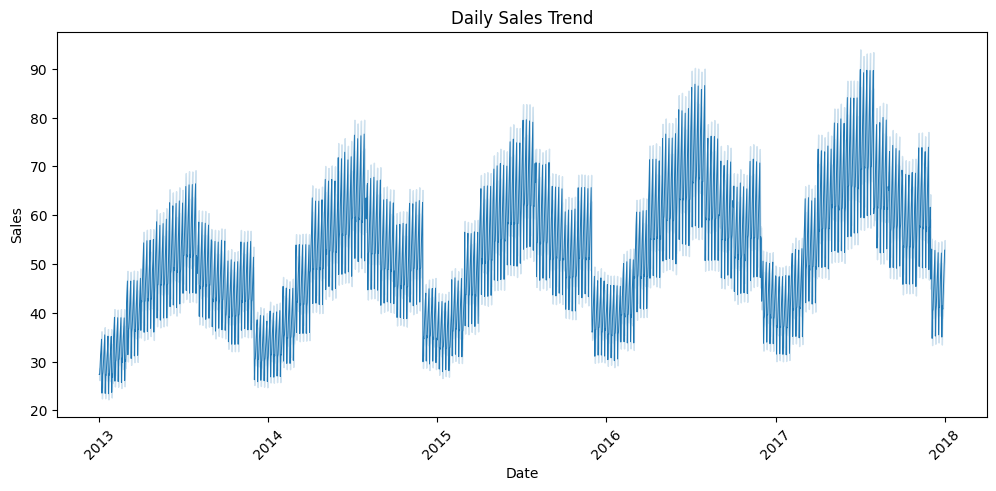

In [24]:
plt.figure(figsize=(12,5))
sns.lineplot(x="date",y="sales",data=train_df,linewidth=0.7)
plt.title("Daily Sales Trend")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.xticks(rotation=45) #ทำการปรับ label แกน x 45 องศา
plt.show()

##### ดูว่าข้อมูลมี Trend แบบไหนด้วย Linear Trend Line

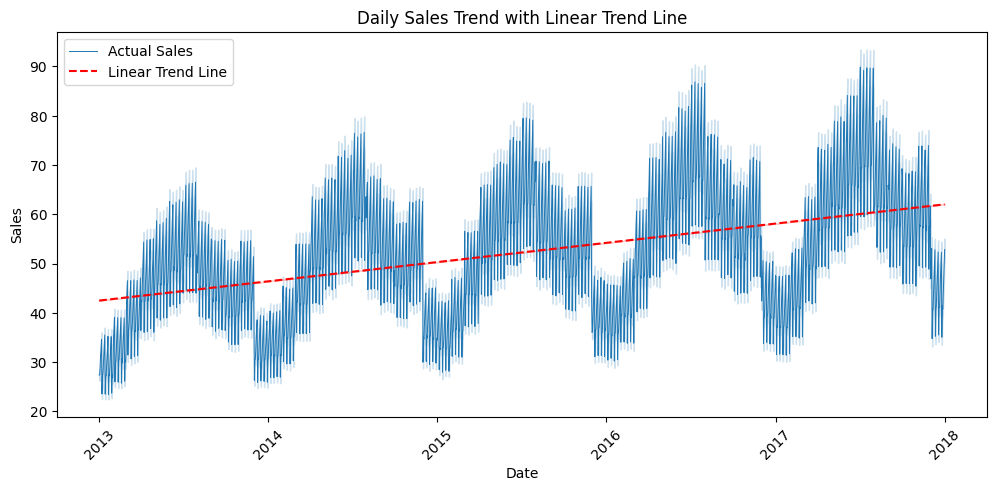

In [36]:
# แปลงวันที่เป็นตัวเลข
train_df["date_numeric"] = (train_df["date"] - train_df["date"].min()).dt.days  

# Fit Linear Regression (y = mx + b)
m, b = np.polyfit(train_df["date_numeric"], train_df["sales"], 1)  
train_df["trend"] = m * train_df["date_numeric"] + b  # คำนวณค่าของเส้นแนวโน้ม

# วาดกราฟ
plt.figure(figsize=(12, 5))
sns.lineplot(x="date", y="sales", data=train_df, label="Actual Sales", linewidth=0.7)
sns.lineplot(x="date", y="trend", data=train_df, color="red", linestyle="dashed", label="Linear Trend Line", linewidth=1.5)

plt.title("Daily Sales Trend with Linear Trend Line")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.xticks(rotation=45)
plt.legend()
plt.show()

##### ดูความสัมพันธ์ของความถี่ของจำนวนการขายด้วย histogram และเส้นความหนาแน่น
* bins=30 --> แบ่ง sales ออกเป็น 30 ช่วง
* kde=True --> พิ่มเส้น Kernel Density Estimate (KDE)

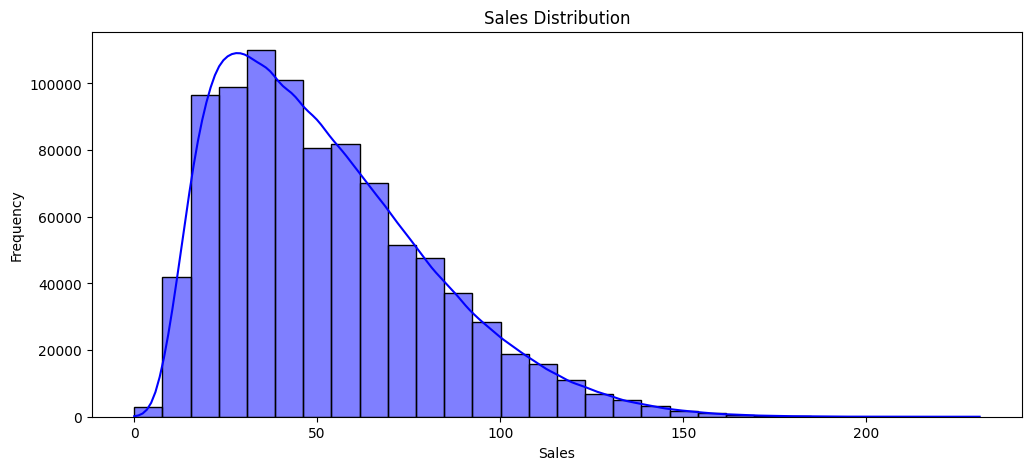

In [26]:
plt.figure(figsize=(12, 5))
sns.histplot(train_df["sales"], bins=30, kde=True, color="blue")
plt.title("Sales Distribution")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.show()

##### ดูความสัมพันธ์ระหว่างค่าเฉลี่ยจำนวนการขายกับ store
* hue="store" --> ใช้คอลัมน์ store เพื่อกำหนดสีของแท่ง
* palette="viridis" --> ใช้สีจากโทนสี "viridis"

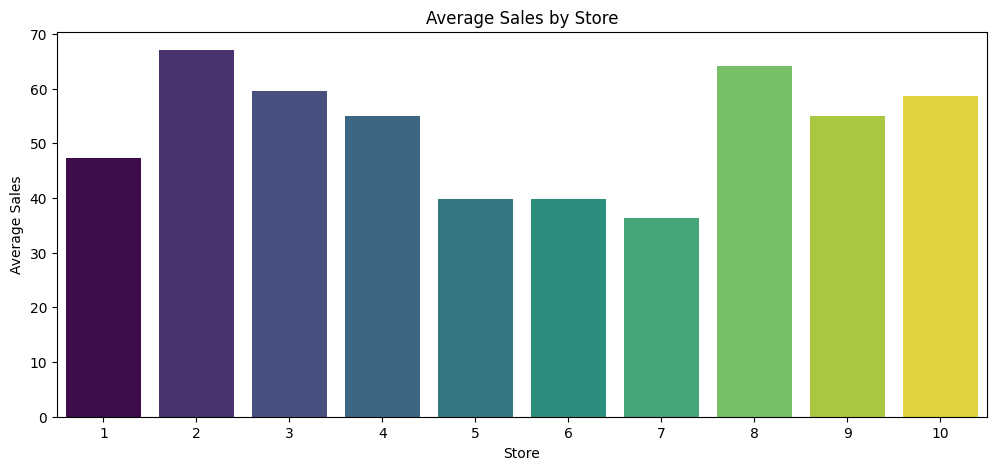

In [32]:
store_sales = train_df.groupby("store")["sales"].mean().reset_index()
plt.figure(figsize=(12, 5))
sns.barplot(x="store", y="sales", data=store_sales,hue="store", palette="viridis",legend=False)
plt.title("Average Sales by Store")
plt.xlabel("Store")
plt.ylabel("Average Sales")
plt.show()

##### ดูรูปแบบของอนุกรมเวลา
* กราฟที่ 1: ข้อมูลดั้งเดิม
* กราฟที่ 2: แนวโน้ม(trend)
* กราฟที่ 3: ฤดูกาล (seasonal)
* กราฟที่ 4: ค่าคลาดเคลื่อน(resid)

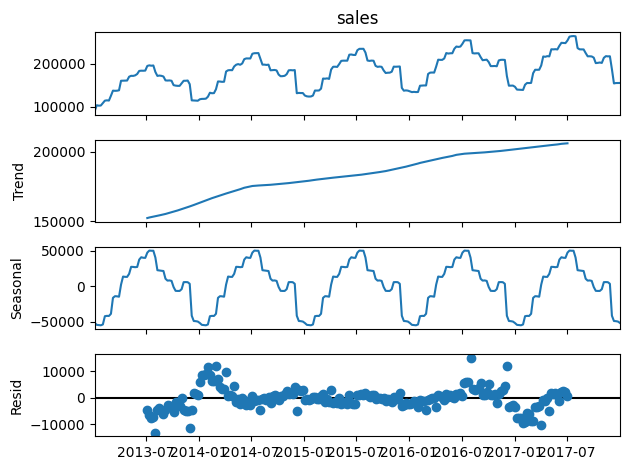

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

df_grouped = train_df.groupby("date")["sales"].sum() #แสดงสินค้าที่ขายได้แต่ละวัน

df_weekly = df_grouped.resample("W").sum() #ลดความถี่รายวันเป็นรายสัปดาห์ (เพื่อดู seasonal ได้ชัดเจน)

# model="additive" ใช้เมื่ออนุกรมเวลารวมกันแบบบวก
result = seasonal_decompose (df_weekly,model="additive",period=52) #ระบุคาบเวลาของ seasonal 52 สัปดาห์

result.plot()
plt.show()

#### Feature Engineering
1. แยก `year` , `month` , `day`
2. `day_of_week` : 0=Monday, 6=Sunday
3. `is_weekend` : เป็นเสาร์อาทิตย์หรือไม่
4. `rolling_mean_7` : ค่าเฉลี่ย sales 7 วันย้อนหลัง เพื่อไห้ ML เรียนรู้ pattern และ trend ได้ดีขึ้นใน time series

In [164]:
train_df["year"] = train_df["date"].dt.year
train_df["month"] = train_df["date"].dt.month
train_df["day"] = train_df["date"].dt.day
train_df["day_of_week"] = train_df["date"].dt.dayofweek
train_df["is_weekend"] = (train_df["day_of_week"] >= 5).astype(int)

# ทำการ groupby แยกประเภทตาม store,item แล้วทำการคำนวณค่าเฉลี่ยน sales 7 วันก่อนหน้า
train_df["rolling_mean_7"] = train_df.groupby(["store","item"])["sales"].transform(
    lambda x : x.rolling(window=7,min_periods=1).mean()
)


train_df["item"] = train_df["item"].astype("category").cat.codes
train_df["store"] = train_df["store"].astype("category").cat.codes

In [73]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            913000 non-null  datetime64[ns]
 1   store           913000 non-null  int8          
 2   item            913000 non-null  int8          
 3   sales           913000 non-null  int64         
 4   year            913000 non-null  int32         
 5   month           913000 non-null  int32         
 6   day             913000 non-null  int32         
 7   day_of_week     913000 non-null  int32         
 8   is_weekend      913000 non-null  int64         
 9   rolling_mean_7  913000 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int32(4), int64(2), int8(2)
memory usage: 43.5 MB


#### visualuzation new feature

##### ดูความสัมพันธ์ระหว่าง Date กับ rolling_mean_7

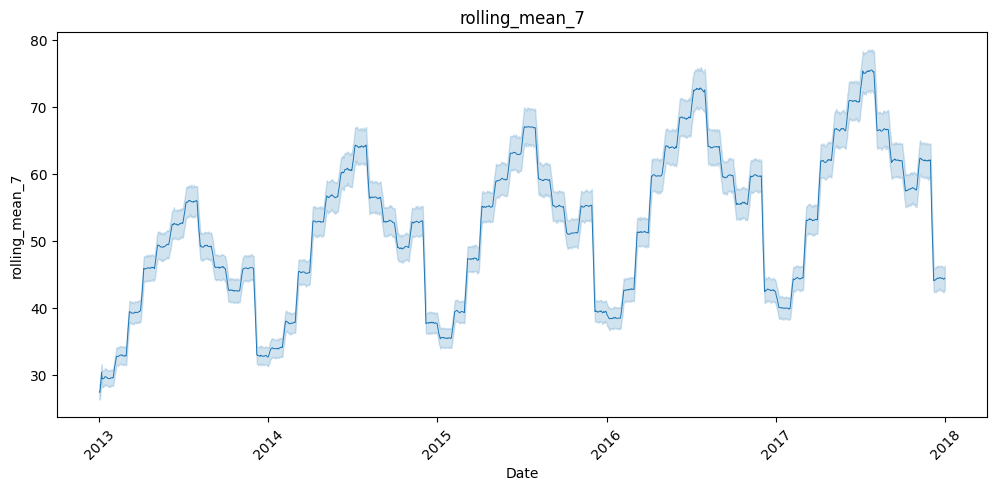

In [44]:
plt.figure(figsize=(12, 5))
sns.lineplot(x="date",y="rolling_mean_7",data=train_df,linewidth=0.7)
plt.title("rolling_mean_7")
plt.xlabel("Date")
plt.ylabel("rolling_mean_7")
plt.xticks(rotation=45)
plt.show()

##### ดูความสัมพันธ์ค่าเฉลี่ยของ sales ตามวันในสัปดาห์

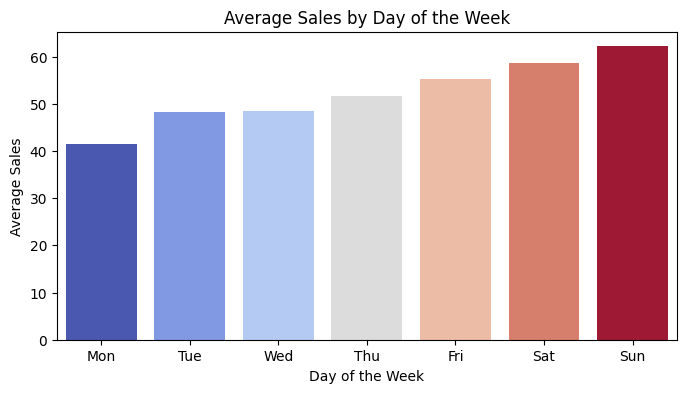

In [64]:
weekly_avg = train_df.groupby("day_of_week")["sales"].mean()
labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

plt.figure(figsize=(8, 4))
sns.barplot(x=weekly_avg.index, y=weekly_avg.values,hue=weekly_avg.index,legend=False,palette="coolwarm")
plt.xticks(ticks=range(7), labels= ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.title("Average Sales by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Average Sales")
plt.show()

##### ดูความสัมพันธ์ค่าเฉลี่ยของ sales ตามเดือน

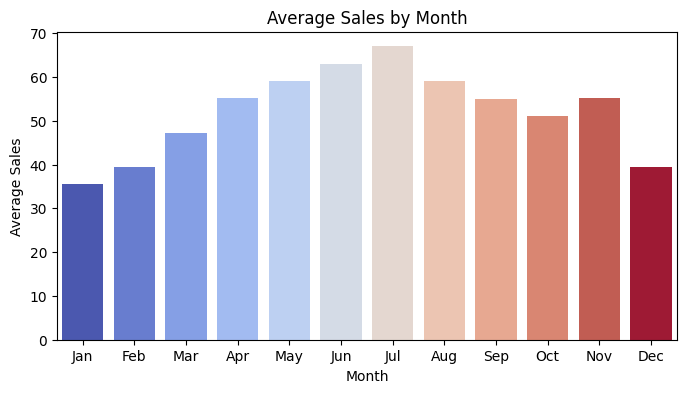

In [65]:
monthly_avg = train_df.groupby("month")["sales"].mean()

plt.figure(figsize=(8, 4))
sns.barplot(x=monthly_avg.index, y=monthly_avg.values, palette="coolwarm",hue=monthly_avg.index,legend=False)

plt.xticks(ticks=range(0, 12), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.title("Average Sales by Month")
plt.xlabel("Month")
plt.ylabel("Average Sales")
plt.show()

#### Summary Of Data Visualization

1. **Trend**:  
   - ยอดขายมีแนวโน้มเพิ่มขึ้นชัดเจนในช่วงเวลาหนึ่ง

2. **Seasonality**:  
   - รายสัปดาห์: ยอดขายสูงในวันเสาร์-อาทิตย์  
   - รายปี: ยอดขายสูงในช่วงเดือนมิถุนายนถึงสิงหาคม (Jun-Aug)

3. **Multivariate Time Series**:  
   - ข้อมูลมีหลายตัวแปรที่ส่งผลต่อยอดขาย  
   - ร้านที่ 2 (`store=2`) มียอดขายสูงที่สุด

4. **Insights**:  
   - วันหยุดสุดสัปดาห์และช่วงกลางปีเป็นช่วงยอดขายดี  
   - ร้านที่ 2 มีประสิทธิภาพการขายสูงสุด|

### Select Model
จากการ visualization ข้อมูลเบื้องต้นที่เป็น `Trend`,`Seasonality`,`Multivariate Time Series` ผมได้ทำการเลือกมา 2 โมเดล

#### 1.XGBoost Model(ประสิทธิภาพดีที่สุด)
> XGBoost (Extreme Gradient Boosting) เป็นอัลกอริทึม Machine Learning แบบ Ensemble Learning ที่ใช้เทคนิค Gradient Boosting เพื่อสร้างโมเดลทำนายที่มีประสิทธิภาพสูง ทำงานโดยการสร้างต้นไม้ตัดสินใจ (Decision Trees) หลาย ๆ ต้น และรวมผลลัพธ์จากต้นไม้เหล่านั้นเพื่อทำนาย

> แม้ XGBoost จะไม่ได้ถูกออกแบบมาเพื่อใช้กับข้อมูล Time Series โดยตรงแต่ XGBoost ก็สามารถใช้งานกับข้อมูล Time Series ได้อย่างมีประสิทธิภาพ หากเราทำ Feature Engineering ที่เหมาะสม เพื่อแปลงข้อมูล Time Series ให้อยู่ในรูปแบบที่ XGBoost สามารถเรียนรู้ได้

In [141]:
#Train-Test-Validation Split (Train 70% , Test 20% ,Val 10%)
trainXG_df, testXG_df = train_test_split(train_df, test_size=0.2, random_state=42, shuffle=False) # suffle=False ไม่สลับข้อมูลก่อนแบ่ง
trainXG_df, valXG_df = train_test_split(trainXG_df, test_size=0.125, random_state=42, shuffle=False)

In [135]:
#Feature Selection
features = ["store", "item", "day_of_week", "year", "month", "day", "is_weekend","rolling_mean_7"]
target = "sales"

X_trainXG, y_trainXG = trainXG_df[features], trainXG_df[target]
X_valXG, y_valXG = valXG_df[features], valXG_df[target]
X_testXG, y_testXG = testXG_df[features], testXG_df[target]

In [136]:
from sklearn.preprocessing import StandardScaler

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_trainXG)
X_val_scaled = scaler.transform(X_valXG)
X_test_scaled = scaler.transform(X_testXG)

In [137]:
X_train_scaled

array([[-1.56669890e+00, -1.68325082e+00, -1.00116454e+00, ...,
        -1.67374446e+00, -6.32697992e-01, -1.51410155e+00],
       [-1.56669890e+00, -1.68325082e+00, -5.00993145e-01, ...,
        -1.56009937e+00, -6.32697992e-01, -1.55066937e+00],
       [-1.56669890e+00, -1.68325082e+00, -8.21749281e-04, ...,
        -1.44645428e+00, -6.32697992e-01, -1.52629082e+00],
       ...,
       [ 1.56669890e+00,  1.68325082e+00,  4.99349647e-01, ...,
         1.50831804e+00, -6.32697992e-01,  2.56825718e-01],
       [ 1.56669890e+00,  1.68325082e+00,  9.99521043e-01, ...,
         1.62196313e+00,  1.58053291e+00,  1.52346233e-01],
       [ 1.56669890e+00,  1.68325082e+00,  1.49969244e+00, ...,
         1.73560822e+00,  1.58053291e+00,  1.73242130e-01]],
      shape=(639100, 8))

In [138]:
#Train XGBoost Model
xgb_model = xgb.XGBRegressor(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=5, 
    random_state=42,
    early_stopping_rounds=10,
    eval_metric="rmse"
)

#แก้ไขตรง eval_set
xgb_model.fit(
    X_train_scaled, y_trainXG,
    eval_set=[(X_train_scaled, y_trainXG), (X_val_scaled, y_valXG)], 
    verbose=True
)

[0]	validation_0-rmse:26.53836	validation_1-rmse:27.09639
[1]	validation_0-rmse:24.14700	validation_1-rmse:24.62860
[2]	validation_0-rmse:22.00782	validation_1-rmse:22.42371
[3]	validation_0-rmse:20.09941	validation_1-rmse:20.45490
[4]	validation_0-rmse:18.39678	validation_1-rmse:18.69921
[5]	validation_0-rmse:16.88655	validation_1-rmse:17.13347
[6]	validation_0-rmse:15.54665	validation_1-rmse:15.74296
[7]	validation_0-rmse:14.36668	validation_1-rmse:14.51611
[8]	validation_0-rmse:13.32358	validation_1-rmse:13.43388
[9]	validation_0-rmse:12.40996	validation_1-rmse:12.48627
[10]	validation_0-rmse:11.61642	validation_1-rmse:11.66357
[11]	validation_0-rmse:10.92452	validation_1-rmse:10.93766
[12]	validation_0-rmse:10.32854	validation_1-rmse:10.31684
[13]	validation_0-rmse:9.81169	validation_1-rmse:9.77590
[14]	validation_0-rmse:9.37229	validation_1-rmse:9.31470
[15]	validation_0-rmse:8.99760	validation_1-rmse:8.92024
[16]	validation_0-rmse:8.68018	validation_1-rmse:8.58782
[17]	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [139]:
# ทำนายผล
y_pred = xgb_model.predict(X_test_scaled)
y_pred = np.round(y_pred).astype(int)

In [140]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# 🔹 Evaluate Metrics
mae = mean_absolute_error(y_testXG, y_pred)
rmse = np.sqrt(mean_squared_error(y_testXG, y_pred))
r2 = r2_score(y_testXG, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

MAE: 4.77
RMSE: 6.20
R² Score: 0.9402


### Test XGBoost

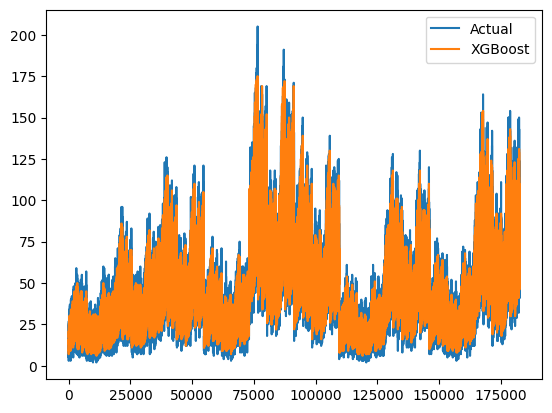

In [116]:
plt.plot(y_testXG.values, label="Actual")
plt.plot(y_pred, label="XGBoost")
plt.legend()
plt.show()

##### Loss Curve
> Loss Curve คือ กราฟที่แสดงการเปลี่ยนแปลงของค่า Loss ในระหว่างการฝึกโมเดล โดยทั่วไปจะแสดงค่า Loss บนชุดข้อมูล Training และ Validation เพื่อตรวจสอบว่าโมเดลเรียนรู้ได้ดีแค่ไหน และตรวจสอบ Overfitting และ Underfitting

* Validation Loss ลดลงและใกล้เคียงกับ Training Loss แสดงว่าโมเดลเรียนรู้ได้ดี

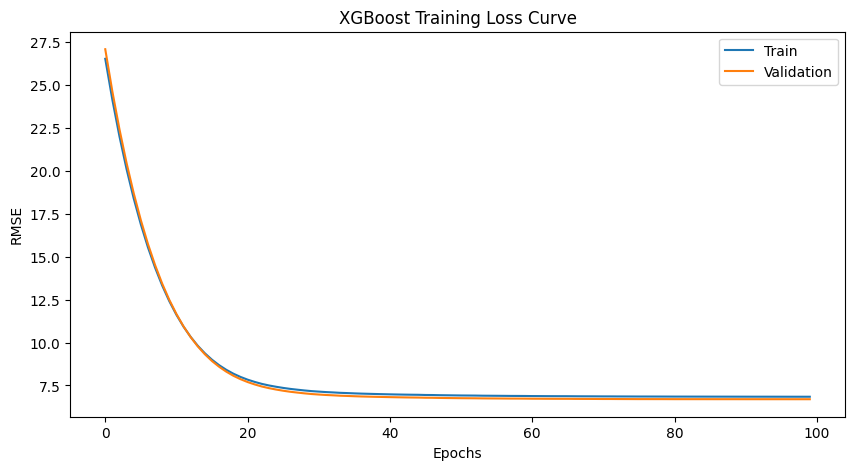

In [117]:
# Plot Loss Curve
results = xgb_model.evals_result()
epochs = len(results["validation_0"]["rmse"])
x_axis = range(0, epochs)

plt.figure(figsize=(10,5))
plt.plot(x_axis, results["validation_0"]["rmse"], label="Train")
plt.plot(x_axis, results["validation_1"]["rmse"], label="Validation")  # ✅ ใช้ได้แล้ว
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.title("XGBoost Training Loss Curve")
plt.legend()
plt.show()

In [91]:
# Load test data
test_df = pd.read_csv("test.csv")
test_df["date"] = pd.to_datetime(test_df["date"])

# Feature Engineering
test_df["year"] = test_df["date"].dt.year
test_df["month"] = test_df["date"].dt.month
test_df["day"] = test_df["date"].dt.day
test_df["day_of_week"] = test_df["date"].dt.dayofweek
test_df["is_weekend"] = (test_df["day_of_week"] >= 5).astype(int)

test_df["rolling_mean_7"] = np.nan

In [92]:
# รวม train และ test data
combined_df = pd.concat([train_df,test_df],axis=0).reset_index(drop=True)
combined_df = combined_df.drop("id",axis=1)

#เพิ่ม column เพื่อระบุว่าเป็นข้อมูล train หรือ test
combined_df["is_test"] = combined_df["sales"].isna() 

In [93]:
combined_df

,date,store,item,sales,year,month,day,day_of_week,is_weekend,rolling_mean_7,is_test
0,2013-01-01,0,0,13.0,2013,1,1,1,0,13.000000,False
1,2013-01-02,0,0,11.0,2013,1,2,2,0,12.000000,False
2,2013-01-03,0,0,14.0,2013,1,3,3,0,12.666667,False
3,2013-01-04,0,0,13.0,2013,1,4,4,0,12.750000,False
4,2013-01-05,0,0,10.0,2013,1,5,5,1,12.200000,False
...,...,...,...,...,...,...,...,...,...,...,...
957995,2018-03-27,10,50,NaN,2018,3,27,1,0,NaN,True
957996,2018-03-28,10,50,NaN,2018,3,28,2,0,NaN,True
957997,2018-03-29,10,50,NaN,2018,3,29,3,0,NaN,True
957998,2018-03-30,10,50,NaN,2018,3,30,4,0,NaN,True


In [94]:
#function ใช้ในการคำนวณ rolling_mean_7 ใน test data และ ทำนาย sales แต่ละบรรทัด
def predict_with_rolling_mean(combined_df,model,scaler,features):
    #จัดกลุ่มตาม store และ item
    grouped = combined_df.groupby(["store","item"])
    results = []

    #for loop ทีละกลุ่ม
    for (store,item),group in grouped:
        # คัดลอกกลุ่มเพื่อป้องกันการแก้ไขข้อมูลต้นฉบับ
        group = group.copy().reset_index(drop=True)
        # วนลูปเพื่อคำนวณ rolling mean และทำนายผล
        for i in range(len(group)):
            if group.loc[i,"is_test"]:
                #คำนวณ rolling mean จาก 7 วันก่อนหน้า
                if i>= 7:
                    group.loc[i, "rolling_mean_7"] = group.loc[i-7:i-1,"sales"].mean()
                else:
                    #ถ้ามีไม่ถึง 7 แถวไห้ใช้เฉพาะข้อมูลที่มีอยู่
                    group.loc[i, "rolling_mean_7"] = group.loc[:i-1,"sales"].mean()

            #เตรียมข้อมูลสำหรับการทำนาย
            X_test = group.loc[i,features].values.reshape(1,-1)

            #แปลงกลับไห้อยู่ในรูป DataFrame
            X_test_df = pd.DataFrame(X_test,columns= features)

            #ปรับ scale
            X_test_scaled = scaler.transform(X_test_df)

            #Predict
            predicted_sales = model.predict(X_test_scaled)
            group.loc[i,"sales"] = np.round(predicted_sales).astype(int)

        #เก็บค่าใน result
        results.append(group)

    #รวมผลลัพธ์จากทุกกลุ่ม
    combined_df = pd.concat(results,axis=0).reset_index(drop=True)
    return combined_df
        
    

In [95]:
# ทำนายผลและคำนวณ rolling mean สำหรับ test data
combined_df = predict_with_rolling_mean(combined_df, xgb_model, scaler, features)

In [103]:
combined_df[combined_df["is_test"]]

,date,store,item,sales,year,month,day,day_of_week,is_weekend,rolling_mean_7,is_test
94952,2018-01-01,1,1,52.0,2018,1,1,0,0,65.000000,True
94953,2018-01-02,1,1,60.0,2018,1,2,1,0,65.571429,True
94954,2018-01-03,1,1,60.0,2018,1,3,2,0,66.000000,True
94955,2018-01-04,1,1,66.0,2018,1,4,3,0,65.857143,True
94956,2018-01-05,1,1,69.0,2018,1,5,4,0,65.714286,True
...,...,...,...,...,...,...,...,...,...,...,...
957995,2018-03-27,10,50,123.0,2018,3,27,1,0,133.142857,True
957996,2018-03-28,10,50,123.0,2018,3,28,2,0,133.142857,True
957997,2018-03-29,10,50,134.0,2018,3,29,3,0,133.142857,True
957998,2018-03-30,10,50,142.0,2018,3,30,4,0,133.428571,True


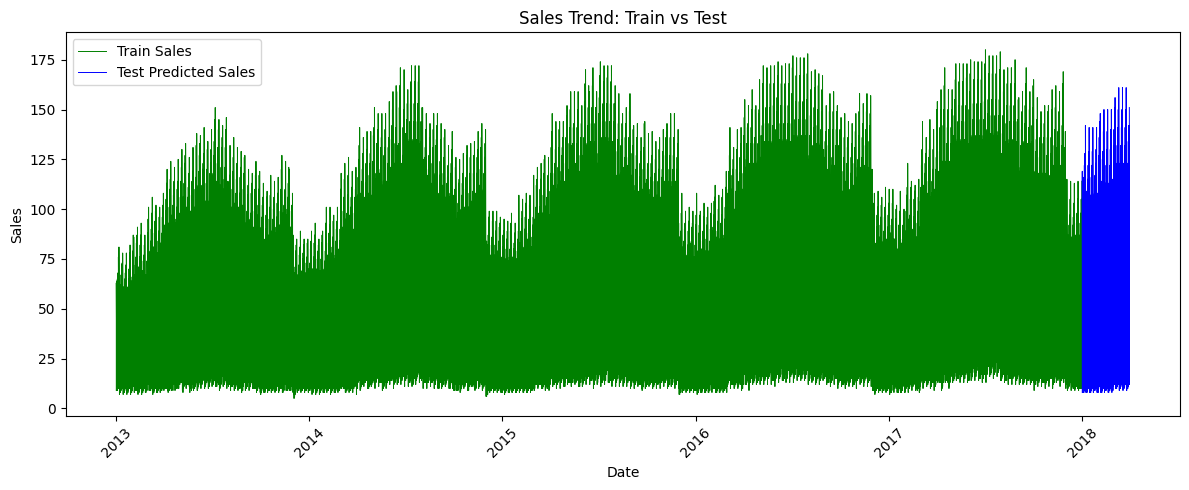

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

# แยกข้อมูล train และ test จาก combined_df
train_df_plot = combined_df[~combined_df["is_test"]].copy()  # ข้อมูล train
test_df_plot = combined_df[combined_df["is_test"]].copy()    # ข้อมูล test

# เรียงลำดับข้อมูล train และ test ตามวันที่
train_df_plot = train_df_plot.sort_values("date")
test_df_plot = test_df_plot.sort_values("date")

# Plot กราฟ
plt.figure(figsize=(12, 5))

# Plot train sales
sns.lineplot(x="date", y="sales", data=train_df_plot, linewidth=0.7, label="Train Sales", color='green',  estimator=None)

# Plot predicted sales for test
sns.lineplot(x="date", y="sales", data=test_df_plot, linewidth=0.7, label="Test Predicted Sales", color='blue',  estimator=None)

# เพิ่ม title และ label
plt.title("Sales Trend: Train vs Test")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.xticks(rotation=45)  # หมุน label บนแกน x เพื่อให้อ่านง่าย
plt.legend()  # แสดง legend
plt.tight_layout()  # ปรับ layout เพื่อป้องกันการตัดข้อความ
plt.show()

#### 2.LSTM(Long Short-Term Memory)(เปรียบเทียบ)
>เป็นหนึ่งในประเภทของ Recurrent Neuron Network(RNN)ที่ออกแบบมาเพื่อแก้ปัญหาการเรียนรู้ข้อมูลระยะยาวในลำดับข้อมูลเช่น ข้อมูลอนุกรมเวลา,ข้อความ

In [74]:
train_df = pd.read_csv("train.csv")
train_df['date'] = pd.to_datetime(train_df['date'], format="%d/%m/%Y")
train_df["year"] = train_df["date"].dt.year
train_df["month"] = train_df["date"].dt.month
train_df["day"] = train_df["date"].dt.day
train_df["day_of_week"] = train_df["date"].dt.dayofweek
train_df["is_weekend"] = (train_df["day_of_week"] >= 5).astype(int)

# ทำการ groupby แยกประเภทตาม store,item แล้วทำการคำนวณค่าเฉลี่ยน sales 7 วันก่อนหน้า
train_df["rolling_mean_7"] = train_df.groupby(["store","item"])["sales"].transform(
    lambda x : x.rolling(window=7,min_periods=1).mean()
)

In [75]:
# เลือก Features และ Target
X = train_df[["store", "item", "year", "month", "day", "day_of_week", "is_weekend", "rolling_mean_7"]].values
y = train_df["sales"].values

In [76]:
from sklearn.preprocessing import MinMaxScaler
#แปลงค่าให้เป็น 0-1 ด้วย MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y.reshape(-1, 1))

In [77]:
#แบ่งข้อมูล Train, Validation, Test(Train 80% , Test 10% ,Val 10%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

##### Reshape ให้ข้อมูลเป็น 3 มิติให้เหมาะกับ LSTM(samples, timesteps, features)
* `samples`: จำนวนข้อมูล (เช่น จำนวนแถวใน DataFrame)
* `timesteps`: จำนวนขั้นเวลาในแต่ละลำดับ
    - Timesteps=1 : ข้อมูลของเราไม่มีลำดับเวลาหลายขั้น(ยอดขายรายวันที่แต่ละแถวแทนยอดขายของวันหนึ่ง ๆโดยไม่มีความสัมพันธ์กับวันก่อนหน้า)
    - Timesteps>1 : ข้อมูลมีลำดับเวลาหลายขั้น (เช่น ข้อมูลอนุกรมเวลาที่มี 7 วัน) 
* `features` : จำนวนฟีเจอร์ในแต่ละขั้นเวลา

In [78]:
# Reshape ให้เหมาะกับ LSTM (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

##### Create Model
* Bidirectional LSTM : การใช้ LSTM แบบไปข้างหน้าและย้อนกลับ ทำให้สามารถจับความสัมพันธ์ของข้อมูลได้ดีขึ้น
* return_sequences=True : ใช้เพื่อให้ส่งออกลำดับของข้อมูล (ต้องใช้เมื่อมี LSTM หลายชั้น)
* recurrent_dropout=0.1 : dropout ที่ใช้กับ state ภายในของ LSTM เพื่อลด overfitting
* BatchNormalization() : ใช้เพื่อลดการเปลี่ยนแปลงของการกระจายข้อมูลในแต่ละ batch และช่วยให้การฝึกโมเดลมีเสถียรภาพ
* Dropout(0.3) : ใช้ลด overfitting โดยสุ่มปิดบางนิวรอน (30%)
* Dense(32, activation='relu') : เชื่อมต่อกับนิวรอน 32 ตัว ใช้ฟังก์ชัน ReLU ช่วยในการเรียนรู้คุณสมบัติที่ซับซ้อน
* Dense(1) : เป็น output layer เพื่อพยากรณ์ค่าเดียว
* batch_size=64 : แบ่งข้อมูลออกเป็นชุดย่อย โดยแต่ละรอบโมเดลจะใช้ข้อมูล 64 ตัวอย่าง ต่อการคำนวณ หนึ่งครั้ง ก่อนทำการ backpropagation และอัปเดต weights

In [72]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional,Input
from tensorflow.keras.models import Sequential

# กำหนด input shape
input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, num_features)

model = Sequential([
    Input(shape=input_shape),  # เพิ่ม Input layer เป็นเลเยอร์แรก
    Bidirectional(LSTM(64, activation='tanh', return_sequences=True, recurrent_dropout=0.1)),
    BatchNormalization(),
    Dropout(0.3),

    Bidirectional(LSTM(64, activation='tanh', recurrent_dropout=0.1)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

In [62]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val),
                    callbacks=[early_stop, reduce_lr])

Epoch 1/100
11413/11413 ━━━━━━━━━━━━━━━━━━━━ 63s 5ms/step - loss: 0.0700 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 2/100
11413/11413 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - loss: 0.0019 - val_loss: 7.8598e-04 - learning_rate: 0.0010
Epoch 3/100
11413/11413 ━━━━━━━━━━━━━━━━━━━━ 54s 5ms/step - loss: 0.0016 - val_loss: 8.6611e-04 - learning_rate: 0.0010
Epoch 4/100
11413/11413 ━━━━━━━━━━━━━━━━━━━━ 51s 4ms/step - loss: 0.0015 - val_loss: 8.3158e-04 - learning_rate: 0.0010
Epoch 5/100
11413/11413 ━━━━━━━━━━━━━━━━━━━━ 49s 4ms/step - loss: 0.0014 - val_loss: 7.9426e-04 - learning_rate: 0.0010
Epoch 6/100
11413/11413 ━━━━━━━━━━━━━━━━━━━━ 50s 4ms/step - loss: 0.0014 - val_loss: 7.7886e-04 - learning_rate: 0.0010
Epoch 7/100
11413/11413 ━━━━━━━━━━━━━━━━━━━━ 49s 4ms/step - loss: 0.0014 - val_loss: 7.4627e-04 - learning_rate: 0.0010
Epoch 8/100
11413/11413 ━━━━━━━━━━━━━━━━━━━━ 49s 4ms/step - loss: 0.0013 - val_loss: 7.3753e-04 - learning_rate: 2.0000e-04
Epoch 9/100
11413/11413 ━━━━━━━━━━━━━━━━

In [63]:
#ทำนายผลจากโมเดล
y_pred = model.predict(X_test)

#แปลงค่าให้กลับเป็นค่าเดิมที่ไม่ได้ถูก Normalize
y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_pred_inv = np.round(y_pred_inv).astype(int) 

2854/2854 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


In [64]:
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2 = r2_score(y_test_inv, y_pred_inv)
    
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

MAE: 4.8983
RMSE: 6.3524
R² Score: 0.9294


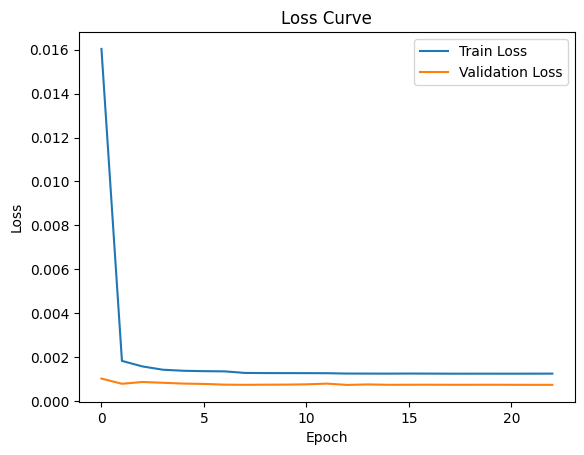

In [65]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

In [66]:
# Load test data
test_df = pd.read_csv("test.csv")
test_df["date"] = pd.to_datetime(test_df["date"])

# Feature Engineering
test_df["year"] = test_df["date"].dt.year
test_df["month"] = test_df["date"].dt.month
test_df["day"] = test_df["date"].dt.day
test_df["day_of_week"] = test_df["date"].dt.dayofweek
test_df["is_weekend"] = (test_df["day_of_week"] >= 5).astype(int)

test_df["rolling_mean_7"] = np.nan

In [67]:
# รวม train และ test data เพื่อคำนวณ rolling mean สำหรับ test data
combined2_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)
combined2_df = combined2_df.drop("id", axis=1)
# กำหนดคอลัมน์เพื่อระบุว่าข้อมูลเป็น train หรือ test
combined2_df["is_test"] = combined2_df["sales"].isna()

In [68]:
def predict_with_rolling_mean2(combined_df, model, scaler_X, scaler_y, features):
    # จัดกลุ่มตาม store และ item
    grouped = combined_df.groupby(["store", "item"])
    
    # เก็บผลลัพธ์
    results = []
    
    # วนลูปตามแต่ละกลุ่ม
    for (store, item), group in grouped:
        # คัดลอกกลุ่มเพื่อป้องกันการแก้ไขข้อมูลต้นฉบับ
        group = group.copy().reset_index(drop=True)
        
        # วนลูปเพื่อคำนวณ rolling mean และทำนายผล
        for i in range(len(group)):
            if group.loc[i, "is_test"]:
                # คำนวณ rolling mean จาก 7 วันก่อนหน้า
                if i >= 7:
                    group.loc[i, "rolling_mean_7"] = group.loc[i-7:i-1, "sales"].mean()
                else:
                    # ถ้าไม่พอ 7 วัน ให้ใช้ข้อมูลที่มีอยู่
                    group.loc[i, "rolling_mean_7"] = group.loc[:i-1, "sales"].mean()
                
                # เตรียมข้อมูลสำหรับการทำนาย
                X_test = group.loc[i, features].values.reshape(1, -1)
                X_test_scaled = scaler_X.transform(X_test)
                
                # Reshape ข้อมูลให้มีรูปร่าง (1, 1, num_features) เพื่อให้ตรงกับที่โมเดลคาดหวัง
                X_test_scaled = X_test_scaled.reshape((1, 1, X_test_scaled.shape[1]))
                
                # ทำนายผล
                predicted_sales_scaled = model.predict(X_test_scaled)
                predicted_sales = scaler_y.inverse_transform(predicted_sales_scaled)
                group.loc[i, "sales"] = np.round(predicted_sales).astype(int)
        
        # เพิ่มกลุ่มที่ประมวลผลแล้วเข้าไปในผลลัพธ์
        results.append(group)
    
    # รวมผลลัพธ์จากทุกกลุ่ม
    combined_df = pd.concat(results, axis=0).reset_index(drop=True)
    return combined_df

In [ ]:
# กำหนด features ที่ใช้ในการทำนาย
features = ["store", "item", "year", "month", "day", "day_of_week", "is_weekend", "rolling_mean_7"]

# ทำนายผลและคำนวณ rolling mean สำหรับ test data
combined2_df = predict_with_rolling_mean2(combined2_df, model, scaler_X, scaler_y, features)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

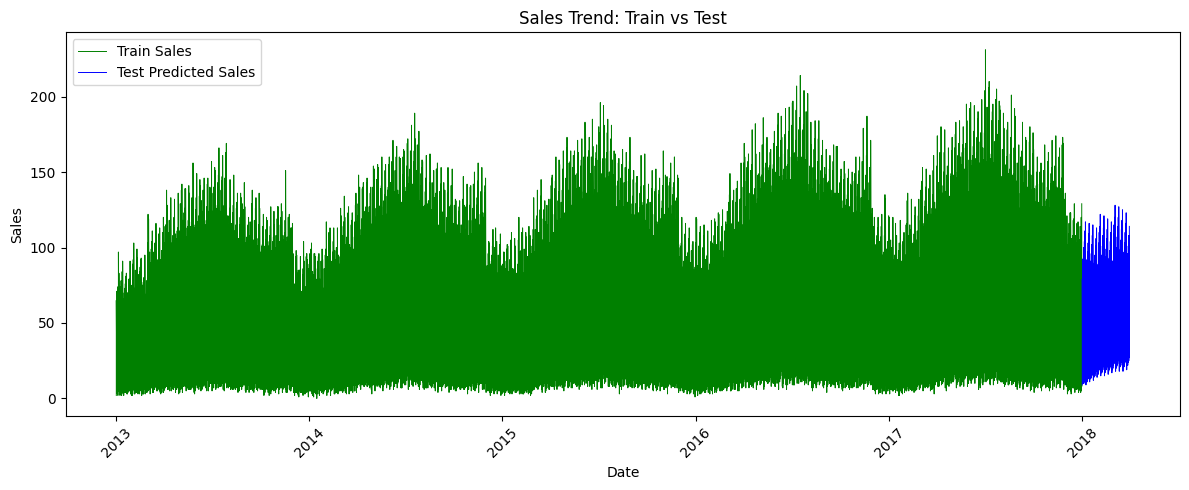

In [71]:
# แยกข้อมูล train และ test จาก combined_df
train_df_plot = combined2_df[~combined2_df["is_test"]].copy()  # ข้อมูล train
test_df_plot = combined2_df[combined2_df["is_test"]].copy()    # ข้อมูล test

# เรียงลำดับข้อมูล train และ test ตามวันที่
train_df_plot = train_df_plot.sort_values("date")
test_df_plot = test_df_plot.sort_values("date")

# Plot กราฟ
plt.figure(figsize=(12, 5))

# Plot train sales
sns.lineplot(x="date", y="sales", data=train_df_plot, linewidth=0.7, label="Train Sales", color='green',  estimator=None)

# Plot predicted sales for test
sns.lineplot(x="date", y="sales", data=test_df_plot, linewidth=0.7, label="Test Predicted Sales", color='blue',  estimator=None)

# เพิ่ม title และ label
plt.title("Sales Trend: Train vs Test")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.xticks(rotation=45)  # หมุน label บนแกน x เพื่อให้อ่านง่าย
plt.legend()  # แสดง legend
plt.tight_layout()  # ปรับ layout เพื่อป้องกันการตัดข้อความ
plt.show()

### เปรียบเทียบโมเดล XGBoost และ LSTM

#### ประสิทธิภาพของโมเดล
จากการทดสอบโมเดลทั้งสอง พบว่า **XGBoost** ให้ประสิทธิภาพที่ดีกว่า **LSTM** ในทุกเมตริกที่วัดได้ ดังนี้:

##### XGBoost
- **MAE (Mean Absolute Error)**: 4.77
- **RMSE (Root Mean Squared Error)**: 6.20
- **R² Score**: 0.9402

##### LSTM
- **MAE (Mean Absolute Error)**: 4.8983
- **RMSE (Root Mean Squared Error)**: 6.3524
- **R² Score**: 0.9294

#### ความเร็วในการประมวลผล
- **XGBoost** ประมวลผลได้เร็วกว่า **LSTM** เนื่องจาก XGBoost ใช้เทคนิคการประมวลผลแบบขนานและโครงสร้างที่เหมาะสมสำหรับข้อมูลแบบตาราง

#### ความสามารถในการรองรับ Seasonality และ Trend
- จากรูปที่ 1 (XGBoost) พบว่าโมเดลสามารถรองรับ **Seasonality** และ **Trend** ได้ดีกว่า เนื่องจากมีการทำ Feature Engineering ที่เหมาะสม
- จากรูปที่ 2 (LSTM) พบว่าโมเดลสามารถจับรูปแบบที่ซับซ้อนได้ดี แต่ไม่สามารถรองรับ Seasonality และ Trend ได้ดีเท่า XGBoost

#### สรุป
- **XGBoost** เหมาะสำหรับข้อมูล Time Series ที่มีการทำ Feature Engineering ที่ดี และต้องการความเร็วในการประมวลผล
- **LSTM** เหมาะสำหรับข้อมูลที่มีความซับซ้อนสูงและต้องการจับ Long-Term Dependencies แต่ใช้เวลาประมวลผลนานกว่า

ดังนั้น ในกรณีนี้ <mark style="background-color: yellow;">**XGBoost**</mark> เป็นโมเดลที่เหมาะสมกว่าเนื่องจากให้ประสิทธิภาพที่ดีกว่าและประมวลผลได้เร็วกว่า